In [1]:
import os
import tensorflow as tf
import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
warnings.filterwarnings("ignore")
tf.get_logger().setLevel('ERROR')

2025-06-15 11:10:51.466041: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749978651.480448   13463 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749978651.484938   13463 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749978651.496218   13463 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749978651.496241   13463 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749978651.496243   13463 computation_placer.cc:177] computation placer alr

## The Perceptron

In [2]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 0) # Iris setosa

per_clf = Perceptron(random_state=42)
per_clf.fit(X, y)

X_new = [[2, 0.5], [3, 1]]
y_pred = per_clf.predict(X_new) # Predicts true/false for these two flowers

for i in range(2):
    print(f"Prediction for {X_new[i]} - {y_pred[i]}")

Prediction for [2, 0.5] - True
Prediction for [3, 1] - False


Scikit-learn's ```Perceptron``` class is equivalent to using ```SDGClassifier``` with the follwing hyperparameters:
```loss="perceptron", learning_rate="constant", eta0=1, penalty=None``` (no regularization)

#### Activation functions
![](images/activation_functions.png)

## Regression MLPs

In [3]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

mlp_reg = MLPRegressor(hidden_layer_sizes=[50, 50, 50], random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_reg)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_valid)
rmse = root_mean_squared_error(y_valid, y_pred)

print(f"RMSE: {root_mean_squared_error(y_valid, y_pred):.3f}")

RMSE: 0.505


#### Typical regression MLP architecture

| Hyperparameter | Typical value |
|-|-|
| # hidden layers | Depends on the problem, but typically 1 to 5 |
| # neurons per hidden layer | Depends on the problem, but typically 10 to 100 |
| # output neurons | 1 per prediction dimension |
| Hidden activation | ReLU |
| Output activation | None, or ReLU/softplus (if positive outputs) or sigmoid/tanh (if bounded outputs) |
| Loss function | MSE, or Huber if outliers |


## Classification MLPs

In [4]:
from sklearn.neural_network import MLPClassifier

iris = load_iris()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    iris.data, iris.target, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42)

mlp_clf = MLPClassifier(hidden_layer_sizes=[5], random_state=42, max_iter=10000)
pipeline = make_pipeline(StandardScaler(), mlp_clf)
pipeline.fit(X_train, y_train)
accuracy = pipeline.score(X_valid, y_valid)

print(f"accuracy: {accuracy}")

accuracy: 1.0


#### Typical classification MLP architecture

| Hyperparameter | Binary classification | Multilabel binary classification | Multiclass classification | 
|-|-|-|-|
| # hidden layers | 1-5 | 1-5 | 1-5 |
| # output neurons | 1 | 1 per binary label | 1 per class |
| Output layer activation | Sigmoid | Sigmoid | Softmax | 
| Loss function | X-entropy | X-entropy | X-entropy |

## Implementing MLP's with Keras

#### Using Keras to load the dataset

In [5]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

X_train.shape

(55000, 28, 28)

In [6]:
X_train.dtype

dtype('uint8')

Let's scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.0

In [7]:
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

Corresponding class names

In [8]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

class_names[y_train[0]]

'Ankle boot'

#### Samples from Fashion MNIST

![](images/fashion_mnist)

#### Creating the model using the sequential API 

In [9]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.Input(shape=(28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

W0000 00:00:1749978660.841189   13463 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In the last ```Dense``` output layer we use 10 neurons (one per each class) with the softmax activation function, since the classes are exclusive

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

```None``` in the Output Shape means the batch size can be anything

In [11]:
model.layers

[<Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>,
 <Dense name=dense_2, built=True>]

In [12]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [13]:
weights, biases = hidden1.get_weights()

print(weights.shape)
weights

(784, 300)


array([[-0.07056645, -0.04387898,  0.01514648, ...,  0.04810292,
        -0.06593668,  0.02112374],
       [-0.03532089, -0.00354702,  0.0360385 , ...,  0.03631159,
         0.03175954,  0.05111074],
       [ 0.06627835, -0.0505593 , -0.0473302 , ...,  0.01166615,
         0.06947742,  0.00346291],
       ...,
       [-0.01206103, -0.0216612 ,  0.06331001, ..., -0.00728282,
        -0.0455192 ,  0.03146189],
       [-0.06269973,  0.05221781,  0.03873699, ..., -0.06372854,
         0.05536419,  0.05071555],
       [ 0.03177683,  0.04928376, -0.06546997, ...,  0.0635308 ,
        -0.00585747,  0.05130017]], dtype=float32)

In [14]:
print(biases.shape)
biases

(300,)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

#### Compiling the model

In [15]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

We use ```"sparse_categorical_crossentropy"``` loss because we have sparse labels, and the classes are exclusive. If instead we had one target probability per class for each instance (such as one-hot vectors), then we would need to use the ```"categorical_crossentropy"``` loss instead. If we were doing binary classification, then we would use the ```"sigmoid"``` activation function in the output layer instead of the ```"softmax"``` activation function, and we would use the ```"binary_crossentropy"``` loss.

#### Training and evaluating the model

In [16]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6990 - loss: 0.9720 - val_accuracy: 0.8270 - val_loss: 0.5053
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8261 - loss: 0.5059 - val_accuracy: 0.8384 - val_loss: 0.4577
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8428 - loss: 0.4549 - val_accuracy: 0.8420 - val_loss: 0.4343
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8517 - loss: 0.4253 - val_accuracy: 0.8464 - val_loss: 0.4191
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8598 - loss: 0.4035 - val_accuracy: 0.8524 - val_loss: 0.4076
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8646 - loss: 0.3856 - val_accuracy: 0.8564 - val_loss: 0.3988
Epoch 7/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8689 - loss: 0.3706 - val_accuracy: 0.8578 - val_loss: 0.3903
Epoch 8/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8729 - loss: 0.3577 - 

In [17]:
history.params

{'verbose': 'auto', 'epochs': 30, 'steps': 1719}

#### Learning curves

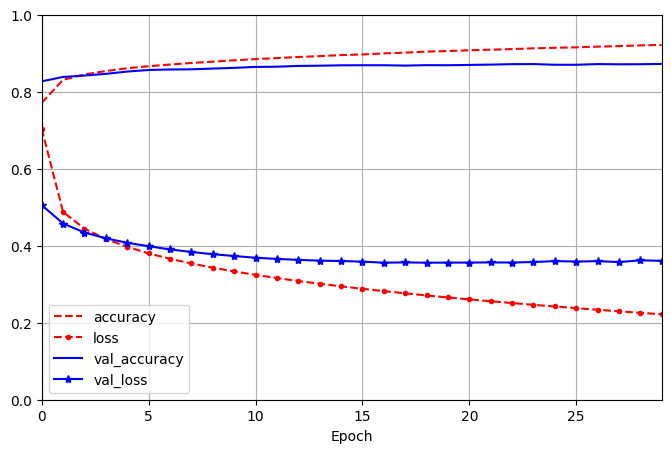

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")
plt.show()

The validation curves are relatively close to each other at first, but they get further apart over time, which shows that there is a bit of overfitting. The model has not quite converged yet, as the validation loss is still going down, so we should probably continue training.

In [19]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - accuracy: 0.8705 - loss: 0.3805


[0.37809091806411743, 0.8707000017166138]

#### Using the model to make predictions

In [20]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.11, 0.  , 0.01, 0.  , 0.88],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [21]:
y_pred = y_proba.argmax(axis=-1)
y_pred

array([9, 2, 1])

In [22]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

![](images/fashion_mnist_predictions)

## Building a regression MLP using the Sequential API

In [23]:
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

In [24]:
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test, rmse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 1.3210 - loss: 1.8965 - val_RootMeanSquaredError: 0.6348 - val_loss: 0.4030
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.6321 - loss: 0.3999 - val_RootMeanSquaredError: 0.7656 - val_loss: 0.5861
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.6035 - loss: 0.3645 - val_RootMeanSquaredError: 0.6690 - val_loss: 0.4475
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.5913 - loss: 0.3498 - val_RootMeanSquaredError: 1.6938 - val_loss: 2.8689
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 0.5832 - loss: 0.3403 - val_RootMeanSquaredError: 1.4340 - val_loss: 2.0564
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.5723 - loss: 0.3276 - val_RootMeanSquaredError: 1.2421 - val_loss: 1.5428
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.5623 - los

Instead of using ```Flatten``` layer, we use ```Normalization``` layer as the first layer: it does the same thing as Scikit-Learn's ```StandardScaler```, but it must be fitted to the training data using its ```adapt()``` method *before* we call the model's ```fit``` method